
# 🛡️ KDD Cup '99 — Intrusion Detection (Google Colab)

This notebook trains a simple **network intrusion detection** model on the classic **KDD Cup '99** dataset.  
We do a **binary task**: **attack (1)** vs **normal (0)** connections.

**You’ll get**
- Data load via `sklearn.datasets.fetch_kddcup99` (stable)
- Preprocessing (one‑hot categorical + scale numeric)
- Model: Logistic Regression (toggle RandomForest)
- Metrics: accuracy, precision, recall, F1, ROC‑AUC
- Plots: Confusion Matrix, ROC
- **Concrete examples**: TP/TN/FP/FN rows + one‑row spotlights
- Quick histograms for a few numeric features

> Tip: KDD’99 is imbalanced & dated; for richer modern traffic consider UNSW‑NB15 or CIC‑IDS2017. This notebook is optimized for **speed and clarity** in class demos.


In [1]:

#@title Setup
import sys, os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
)

warnings.filterwarnings("ignore")

print("Python:", sys.version.split()[0])
import sklearn, pandas, numpy
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)


Python: 3.12.12
scikit-learn: 1.6.1
pandas: 2.2.2
numpy: 2.0.2


In [2]:

#@title Load KDD Cup '99 (with safe downsampling for speed)
# We'll try a small subset 'SA'. If not available, we fetch percent10=True and downsample.
#
# - Features include categorical: protocol_type, service, flag
# - Labels are bytes like b'normal.' or b'neptune.'

def load_kdd99_dataframe():
    try:
        data = fetch_kddcup99(subset="SA", percent10=True, as_frame=True, shuffle=True, random_state=42)
        print("Loaded subset='SA' (fast).")
    except Exception as e:
        print("subset='SA' not available, falling back to 10% file:", e)
        data = fetch_kddcup99(as_frame=True, percent10=True, shuffle=True, random_state=42)
    X = data.data.copy()
    y = data.target.copy()
    # Map to binary: 0=normal, 1=attack
    y_bin = np.array([0 if lbl == b'normal.' else 1 for lbl in y.values])
    # Optional: downsample for speed if very large
    MAX_ROWS = 80000  # adjust if you want faster/slower
    if len(X) > MAX_ROWS:
        from sklearn.utils import resample
        idx = np.arange(len(X))
        rng = np.random.RandomState(42)
        take = rng.choice(idx, size=MAX_ROWS, replace=False)
        X = X.iloc[take].reset_index(drop=True)
        y_bin = y_bin[take]
        print(f"Downsampled to {len(X)} rows for speed.")
    return X, y_bin

X, y = load_kdd99_dataframe()
print("Shape:", X.shape, " Positives (attacks):", int(y.sum()), " Negatives (normal):", int((1-y).sum()))
X.head(3)


Loaded subset='SA' (fast).
Downsampled to 80000 rows for speed.
Shape: (80000, 41)  Positives (attacks): 2680  Negatives (normal): 77320


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,b'tcp',b'http',b'SF',213,1458,0,0,0,0,...,12,255,1.0,0.0,0.08,0.03,0.0,0.0,0.0,0.0
1,0,b'tcp',b'http',b'SF',345,515,0,0,0,0,...,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,b'tcp',b'http',b'SF',219,3084,0,0,0,0,...,23,255,1.0,0.0,0.04,0.06,0.0,0.0,0.0,0.0


In [3]:

#@title Train/test split & preprocessing
cat_cols = ['protocol_type','service','flag']
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(with_mean=False), num_cols),
    ]
)

use_random_forest = False  #@param {type:"boolean"}

if use_random_forest:
    clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
else:
    clf = LogisticRegression(max_iter=300)

pipe = Pipeline([("prep", preprocess), ("clf", clf)])
pipe


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['protocol_type', 'service',
                                                   'flag']),
                                                 ('num',
                                                  StandardScaler(with_mean=False),
                                                  ['duration', 'src_bytes',
                                                   'dst_bytes', 'land',
                                                   'wrong_fragment', 'urgent',
                                                   'hot', 'num_failed_logins',
                                                   'logged_in',
                                                   'num_compromised',
                                                   'root_shell', 'su_attempted',
                                                   'num_root',
                                                   'num_file_creations',
                                                   'num_shells',
                                                   'num_access_files',
                                                   'num_outbound_cmds',
                                                   'is_host_login',
                                                   'is_guest_login', 'count',
                                                   'srv_count', 'serror_rate',
                                                   'srv_serror_rate',
                                                   'rerror_rate',
                                                   'srv_rerror_rate',
                                                   'same_srv_rate',
                                                   'diff_srv_rate',
                                                   'srv_diff_host_rate',
                                                   'dst_host_count',
                                                   'dst_host_srv_count', ...])])),
                ('clf', LogisticRegression(max_iter=300))])

In [4]:

#@title Train & evaluate
pipe.fit(X_train, y_train)
train_pred = pipe.predict(X_train)
test_pred  = pipe.predict(X_test)

print(f"Train acc: {accuracy_score(y_train, train_pred):.4f}")
print(f"Test  acc: {accuracy_score(y_test,  test_pred):.4f}")
print()
print("Classification report (test):")
print(classification_report(y_test, test_pred, digits=4))


Train acc: 0.9996
Test  acc: 0.9993

Classification report (test):
              precision    recall  f1-score   support

           0     0.9994    0.9999    0.9997     19330
           1     0.9970    0.9836    0.9902       670

    accuracy                         0.9993     20000
   macro avg     0.9982    0.9917    0.9949     20000
weighted avg     0.9993    0.9993    0.9993     20000



Test ROC-AUC: 0.9998


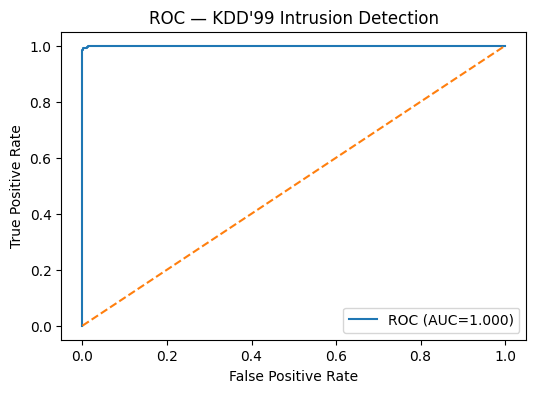

In [5]:

#@title ROC-AUC + ROC curve
# Probability scores
if hasattr(pipe.named_steps["clf"], "predict_proba"):
    test_proba = pipe.predict_proba(X_test)[:,1]
elif hasattr(pipe.named_steps["clf"], "decision_function"):
    raw = pipe.decision_function(X_test)
    raw_min, raw_max = raw.min(), raw.max()
    test_proba = (raw - raw_min) / (raw_max - raw_min + 1e-12)
else:
    test_proba = test_pred.astype(float)

auc = roc_auc_score(y_test, test_proba)
print(f"Test ROC-AUC: {auc:.4f}")

fpr, tpr, thr = roc_curve(y_test, test_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — KDD'99 Intrusion Detection")
plt.legend(loc="lower right")
plt.show()


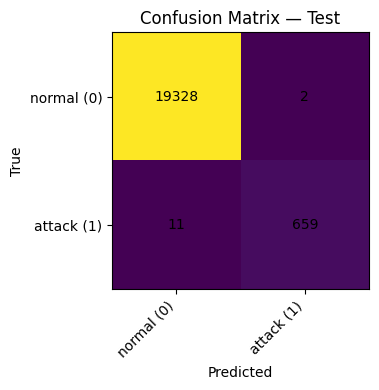

(array([[19328,     2],
        [   11,   659]]),
 array(['normal (0)', 'attack (1)'], dtype='<U10'))

In [6]:

#@title Confusion Matrix (test)
cm = confusion_matrix(y_test, test_pred)
classes = np.array(["normal (0)", "attack (1)"])

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix — Test")
plt.xticks([0,1], classes, rotation=45, ha="right")
plt.yticks([0,1], classes)
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

cm, classes



## 🧪 Examples (TP/TN/FP/FN)

We now surface **actual rows** from the **test set** the model got right/wrong — helpful to discuss which patterns look suspicious vs benign.


In [7]:

#@title Build example buckets and show
import pandas as pd
from IPython.display import display

def collect_examples(X_df, y_true, y_pred, proba=None, max_rows=6):
    idx_all = np.arange(len(y_true))
    is_pos = y_true == 1
    is_neg = ~is_pos

    tp_idx = idx_all[(y_pred == 1) & is_pos]
    tn_idx = idx_all[(y_pred == 0) & is_neg]
    fp_idx = idx_all[(y_pred == 1) & is_neg]
    fn_idx = idx_all[(y_pred == 0) & is_pos]

    def build_df(indices):
        take = indices[:max_rows]
        out = X_df.iloc[take].copy()
        out.insert(0, "y_true", y_true[take])
        out.insert(1, "y_pred", y_pred[take])
        if proba is not None:
            out.insert(2, "p(attack)", proba[take])
        return out.reset_index(drop=True)

    return {
        "TP (attack correctly detected)": build_df(tp_idx),
        "TN (normal correctly detected)": build_df(tn_idx),
        "FP (normal flagged as attack)": build_df(fp_idx),
        "FN (missed attack)": build_df(fn_idx),
    }

examples = collect_examples(X_test.reset_index(drop=True), y_test, test_pred, proba=test_proba, max_rows=6)

print("TP — attack correctly detected")
display(examples["TP (attack correctly detected)"])

print("TN — normal correctly detected")
display(examples["TN (normal correctly detected)"])

print("FP — normal flagged as attack")
display(examples["FP (normal flagged as attack)"])

print("FN — missed attack")
display(examples["FN (missed attack)"])


TP — attack correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,1,0.999298,0,b'icmp',b'ecr_i',b'SF',1032,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1,1,0.998103,0,b'icmp',b'ecr_i',b'SF',520,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,1,0.999298,0,b'icmp',b'ecr_i',b'SF',1032,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,1,0.999957,0,b'tcp',b'private',b'S0',0,0,0,...,255,10,0.04,0.06,0.0,0.0,1.0,1.0,0.0,0.0
4,1,1,0.999901,0,b'tcp',b'private',b'S0',0,0,0,...,255,17,0.07,0.06,0.0,0.0,1.0,1.0,0.0,0.0
5,1,1,0.999298,0,b'icmp',b'ecr_i',b'SF',1032,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


TN — normal correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0.000186,0,b'tcp',b'http',b'SF',347,1838,0,...,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0.000105,300,b'udp',b'other',b'SF',147,105,0,...,255,3,0.01,0.59,0.96,0.0,0.0,0.0,0.0,0.0
2,0,0,0.000039,2620,b'udp',b'other',b'SF',145,105,0,...,255,2,0.01,0.86,0.99,0.0,0.0,0.0,0.0,0.0
3,0,0,0.000181,0,b'tcp',b'http',b'SF',285,9419,0,...,42,49,1.0,0.0,0.02,0.04,0.0,0.0,0.0,0.0
4,0,0,0.000051,0,b'tcp',b'http',b'SF',336,574,0,...,139,255,1.0,0.0,0.01,0.03,0.0,0.0,0.01,0.0
5,0,0,0.000768,0,b'tcp',b'finger',b'SF',6,135,0,...,6,6,0.33,0.33,0.17,0.33,0.0,0.0,0.0,0.0


FP — normal flagged as attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,0.730649,12632,b'tcp',b'telnet',b'SF',3416,34430,0,...,76,16,0.2,0.04,0.01,0.12,0.0,0.06,0.0,0.0
1,0,1,0.987113,28,b'tcp',b'smtp',b'SF',809,479,0,...,240,52,0.16,0.01,0.0,0.04,0.0,0.0,0.84,0.0


FN — missed attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,0,0.000742,0,b'tcp',b'finger',b'S0',0,0,1,...,1,2,1.0,0.0,1.0,1.0,1.0,0.5,0.0,0.0
1,1,0,0.015839,0,b'icmp',b'eco_i',b'SF',8,0,0,...,1,255,1.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0
2,1,0,0.016114,0,b'icmp',b'eco_i',b'SF',8,0,0,...,1,255,1.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0
3,1,0,0.003539,0,b'tcp',b'ftp_data',b'SF',334,0,0,...,2,36,1.0,0.0,1.0,0.06,0.0,0.0,0.0,0.0
4,1,0,0.016967,0,b'icmp',b'eco_i',b'SF',8,0,0,...,1,255,1.0,0.0,1.0,0.5,0.0,0.0,0.0,0.0
5,1,0,0.005179,0,b'tcp',b'http',b'SF',54540,8314,0,...,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.05,0.05



## 📊 Quick visual comparisons

Histograms for a few widely used numeric features over the **test set**, split by **true label**.


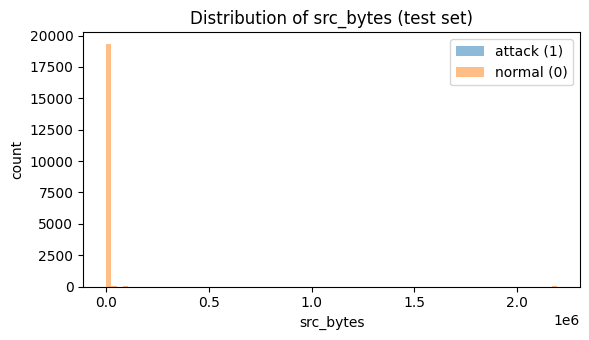

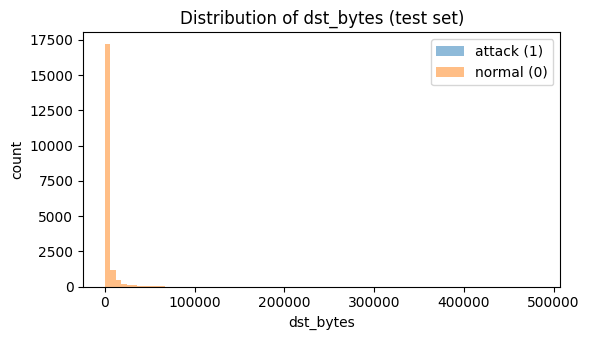

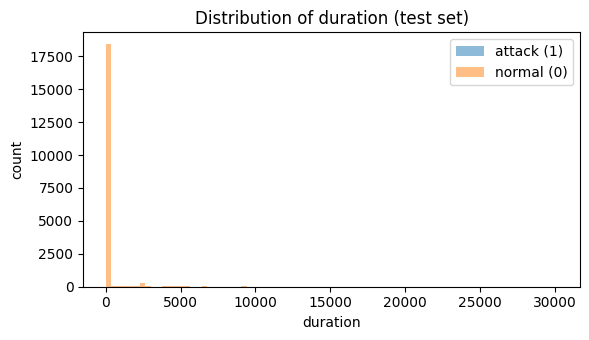

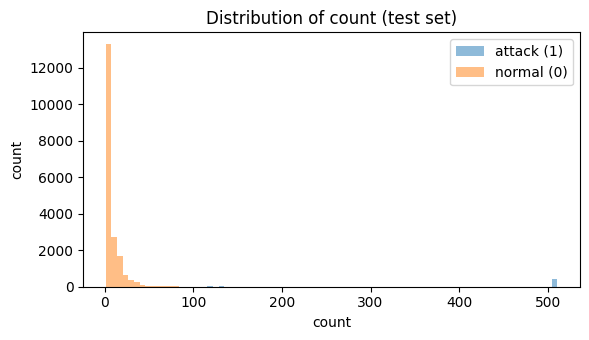

In [8]:

#@title Histograms: src_bytes, dst_bytes, duration, count
att_mask = (y_test == 1)
norm_mask = ~att_mask

def hist_feature(colname, bins=60):
    attack_vals = X_test.loc[att_mask, colname].values
    normal_vals = X_test.loc[norm_mask, colname].values
    plt.figure(figsize=(6,3.5))
    plt.hist(attack_vals, bins=bins, alpha=0.5, label="attack (1)")
    plt.hist(normal_vals, bins=bins, alpha=0.5, label="normal (0)")
    plt.title(f"Distribution of {colname} (test set)")
    plt.xlabel(colname)
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()

for feat in ["src_bytes", "dst_bytes", "duration", "count"]:
    if feat in X_test.columns:
        hist_feature(feat, bins=80)



## 🎯 One-row spotlights (screenshot friendly)


In [9]:

#@title Pretty-print one row from each bucket
from IPython.display import display

def show_one(df, title):
    print("="*len(title))
    print(title)
    print("="*len(title))
    display(df.head(1))

show_one(examples["TP (attack correctly detected)"], "TP — attack correctly detected")
show_one(examples["TN (normal correctly detected)"], "TN — normal correctly detected")
show_one(examples["FP (normal flagged as attack)"], "FP — normal flagged as attack")
show_one(examples["FN (missed attack)"], "FN — missed attack")


TP — attack correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,1,0.999298,0,b'icmp',b'ecr_i',b'SF',1032,0,0,...,255,255,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


TN — normal correctly detected


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0.000186,0,b'tcp',b'http',b'SF',347,1838,0,...,255,255,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


FP — normal flagged as attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,0.730649,12632,b'tcp',b'telnet',b'SF',3416,34430,0,...,76,16,0.2,0.04,0.01,0.12,0.0,0.06,0.0,0.0


FN — missed attack


,y_true,y_pred,p(attack),duration,protocol_type,service,flag,src_bytes,dst_bytes,land,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,1,0,0.000742,0,b'tcp',b'finger',b'S0',0,0,1,...,1,2,1.0,0.0,1.0,1.0,1.0,0.5,0.0,0.0



## 📝 Report notes (talk track)

- Start with the **confusion matrix** and define TP/TN/FP/FN in security terms.  
- Show **ROC curve** and discuss thresholding for **SOC** workflows (trade‑offs between catching attacks vs alert fatigue).  
- Walk through **one TP** and **one FP** to hypothesize **why** the model behaved that way (e.g., high `count`, unusual `service`, low `dst_bytes`).  
- Mention dataset caveats (age, simulated traffic, attack imbalance) and recommend **modern datasets** for production research.
